# Part1：MNIST Digit Classification

该部分已经在之前的文章中实现过了，[github - 手写数字识别全连接神经网路](https://github.com/wty-yy/DeepLearing-Summer/blob/master/TensorFlow/Part2%20Neural%20Networks/Neural%20Networks%20writing%20number.ipynb) 和 [github - 手写数字识别RNN](https://github.com/wty-yy/DeepLearing-Summer/blob/master/TensorFlow/Part2%20Neural%20Networks/Neural%20Networks%20writing%20number%20improved.ipynb)，这里将两个整合到一起，简略写一遍.

图形识别的第一部分为**识别手写数字**，使用的是 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据集，该数据集由 $60000$ 个训练样本和 $10000$ 个测试样本，每个样本的类别为 $0\sim 9$.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers

import mitdeeplearning as mdl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 确保使用的是GPU版本的tensorflow
assert len(tf.config.list_physical_devices('GPU')) > 0

## 1.1 MNIST Dataset

下载数据集并进行简单测试.

训练集样本个数60000, 测试集样本个数10000, 图片格式(28, 28)


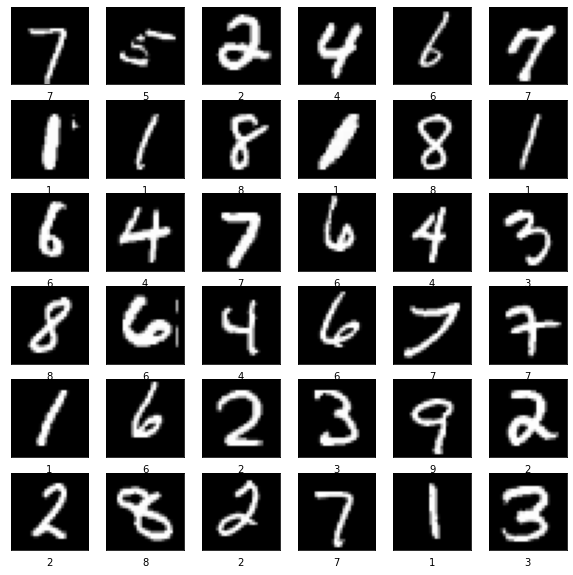

In [2]:
mnist = keras.datasets.mnist
(train, train_y), (test, test_y) = mnist.load_data()
print(f"训练集样本个数{train.shape[0]}, 测试集样本个数{test.shape[0]}, 图片格式{train.shape[1:3]}")

# 对输入数据进行归一化处理在最后一维加上一层，代表颜色通道数，这里只用黑白两种颜色，为灰度单通道，并转化为tensorflow要求的数据类型
train = (np.expand_dims(train / 255., axis=-1)).astype(np.float32)  # tensorflow标准输入的浮点数为float32
test = (np.expand_dims(test / 255., axis=-1)).astype(np.float32)
train_y = train_y.astype(np.int64)  # tensorflow标准整数输入为int64
test_y = test_y.astype(np.int64)

plt.figure(figsize=(10, 10))
random_idx = np.random.choice(60000, 36)  # 从训练集中随机选取36张图片进行显示
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = random_idx[i]
    plt.imshow(train[idx], cmap=plt.cm.gray)  # 设置colormap为灰度
    plt.xlabel(train_y[idx])  # 显示数字标签

## 1.2 Neural Network for Handwritten Digit Classification

首先我们构建一个简单一层全连接神经网路，对手写数字进行预测.

- 输入层：图片展平后作为输入，共包含 $28\times 28 = 784$ 个像素.

- 隐藏层：全连接层，包含 $128$ 个神经元，激活函数使用 `sigmoid` 或 `relu`.

- 输出层：全连接层，包含 $9$ 个神经元，激活函数使用 `softmax`.

![](https://s1.ax1x.com/2022/07/30/vifuD0.png)

In [3]:
# 转化为tf.Dataset数据类型更加规范
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((train, train_y)).batch(batch_size).shuffle(1000)
test_ds = tf.data.Dataset.from_tensor_slices((test, test_y)).batch(batch_size)

In [4]:
def build_dense_model(dense_units=128):
    return keras.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dense(dense_units, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
model = build_dense_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer='Adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
#model.fit(train_ds, validation_data=test_ds, epochs=5)  # 使用tf.Dataset更加方便
model.fit(train, train_y, validation_data=(test, test_y), batch_size=64, epochs=5)

Epoch 1/5
938/938 [==============================] - 3s 2ms/step - loss: 0.2960 - accuracy: 0.9169 - val_loss: 0.1653 - val_accuracy: 0.9510
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1321 - accuracy: 0.9623 - val_loss: 0.1072 - val_accuracy: 0.9678
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0926 - accuracy: 0.9733 - val_loss: 0.0852 - val_accuracy: 0.9737
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0708 - accuracy: 0.9792 - val_loss: 0.0801 - val_accuracy: 0.9740
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0560 - accuracy: 0.9839 - val_loss: 0.0754 - val_accuracy: 0.9757


## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

下面使用卷积神经网路进一步训练，使用两个卷积块，每个卷积块包含一个卷积层和一个最大汇聚层(Max-pooling)，如下图所示：

![](https://s1.ax1x.com/2022/07/30/vi4UAK.png)

值得注意的是，每个卷积块可以使得输入数据降维，从而包含更少的有效数据，对于低维的数据，需要更多的卷积核，即增加卷积层的深度.

可以发现上图中，第一个卷积层包含24个卷积核，第二个卷积层包含36个卷积核.

In [6]:
def build_cnn_model():
    return keras.Sequential([
        layers.Conv2D(32, 5, input_shape=[28, 28, 1]),
        layers.MaxPool2D(2),
        layers.Conv2D(48, 5),
        layers.MaxPool2D(2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 48)          38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               393728    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [7]:
cnn_model.compile(optimizer='Adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
cnn_model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
938/938 [==============================] - 7s 4ms/step - loss: 0.1438 - accuracy: 0.9565 - val_loss: 0.0577 - val_accuracy: 0.9821
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0478 - accuracy: 0.9854 - val_loss: 0.0390 - val_accuracy: 0.9885
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0317 - accuracy: 0.9902 - val_loss: 0.0378 - val_accuracy: 0.9891
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0256 - accuracy: 0.9922 - val_loss: 0.0382 - val_accuracy: 0.9885
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0205 - accuracy: 0.9937 - val_loss: 0.0390 - val_accuracy: 0.9884


## Make predictions with the CNN model

对测试集进行简单预测.

预测值：7


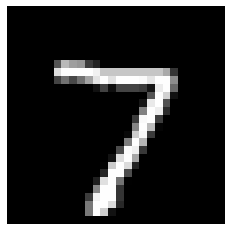

In [8]:
# 获取全部预测数据结果
pred = cnn_model.predict(test)
# 查看第一幅图片的预测值
print(f"预测值：{np.argmax(pred[0])}")
plt.imshow(test[0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

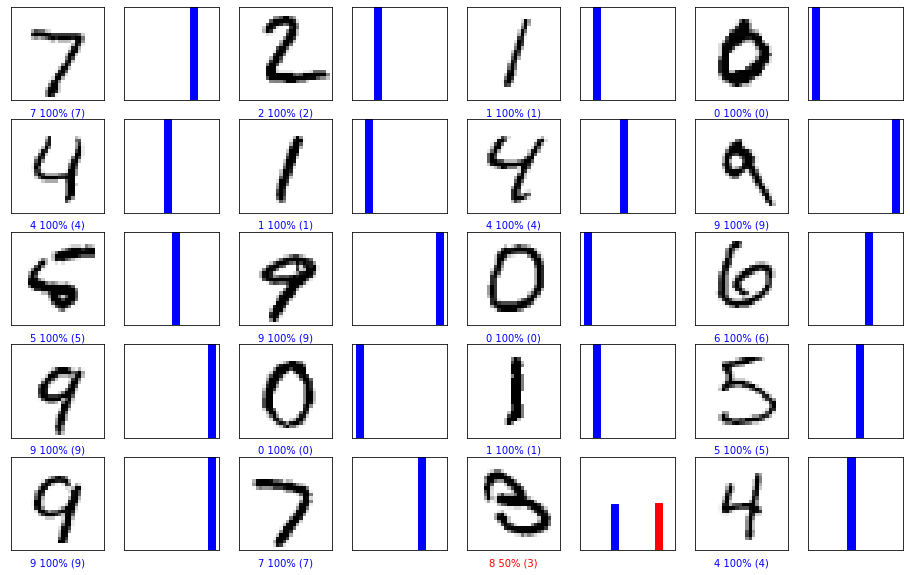

In [9]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, pred, test_y, test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, pred, test_y)

## Training the model 2.0

这里我们再使用 `tf.GradientTap` 自定义方式写一遍训练函数，而不使用 `model.fit` 函数. 因为 `model.fit` 会丢失训练过程中的很多细节.

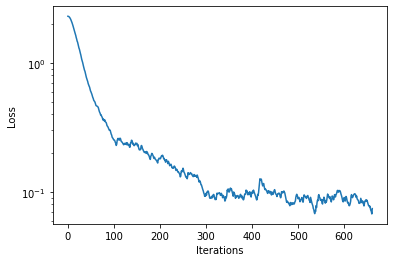

100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 151.89it/s]


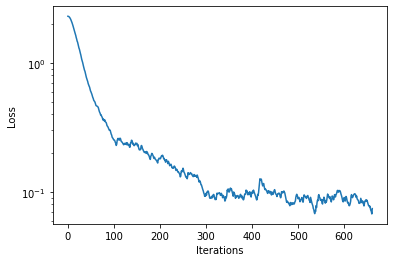

In [10]:
cnn_model = build_cnn_model()

batch_size = 64
# 绘图需要
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.Adam()

for idx in tqdm(range(0, train.shape[0], batch_size)):
    # 划分batch中
    (x, y) = (train[idx:idx+batch_size], train_y[idx:idx+batch_size])
    x = tf.Variable(x, tf.float32)

    with tf.GradientTape() as tape:
        logits = cnn_model(x)
        loss = keras.losses.sparse_categorical_crossentropy(y, logits)

    grads = tape.gradient(loss, cnn_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))
    
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [11]:
cnn_model.compile(optimizer='Adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
cnn_model.evaluate(test_ds)

157/157 [==============================] - 1s 2ms/step - loss: 0.0552 - accuracy: 0.9806


[0.05517473816871643, 0.9805999994277954]